## 2.2. fMRI Preprocessing Pipeline

This notebook introduces the essential preprocessing steps used in fMRI analysis:

- Slice-timing correction  
- Motion correction (realignment)  
- Basic spatial smoothing  
- Understanding BIDS metadata  
- Loading preprocessed data


In [5]:
import sys
sys.path.append("../../") 

import numpy as np
import matplotlib.pyplot as plt
from nilearn.image import index_img, smooth_img, mean_img, math_img
from nilearn.plotting import plot_epi
import nibabel as nib

from neurolib.fmri.io import load_fmri_sample, load_fmri_metadata
from neurolib.fmri.visualization import (
    plot_fmri_epi,
    plot_fmri_diffmap
)

from neurolib.fmri.preprocessing import (
    slice_timing_correction,
    motion_correction,
    smooth_image,
)


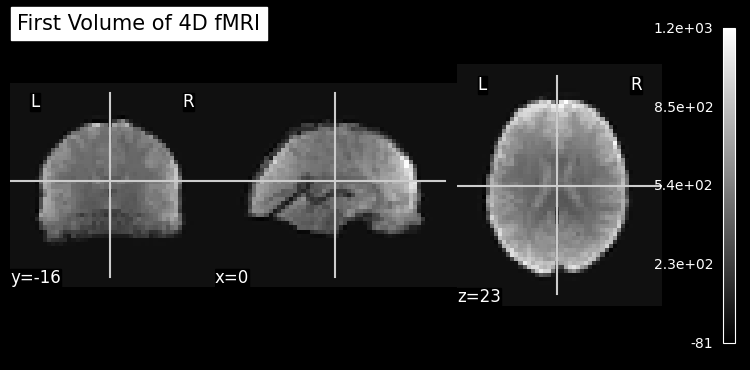

In [6]:
fmri_img = load_fmri_sample()
# Nilearn visualization functions require **3D images**, not 4D.
first_volume_img = index_img(fmri_img, 0)
plot_fmri_epi(first_volume_img, title="First Volume of 4D fMRI")

### Slice Timing Correction (STC): Accounting for Sequential Acquisition

fMRI data is acquired as a 3D volume, but the scanner cannot acquire all slices simultaneously. It acquires them in a specific **sequence** (e.g., interleaved or sequential) over the **Repetition Time (TR)**. This means that, within one TR, the first slice is acquired milliseconds before the last slice.

- **The Problem**: The BOLD signal (our measure of neural activity) is slow, but we need to assume all voxels in the 3D volume were measured at the same time point for accurate statistical analysis.

- **The Solution (STC)**: This step uses **interpolation** (often sinc or spline) to estimate what the signal in each slice would have been if all slices had been acquired exactly at the beginning (or middle) of the TR. This temporal alignment is crucial for studies that model the BOLD response to rapid stimulus presentations.


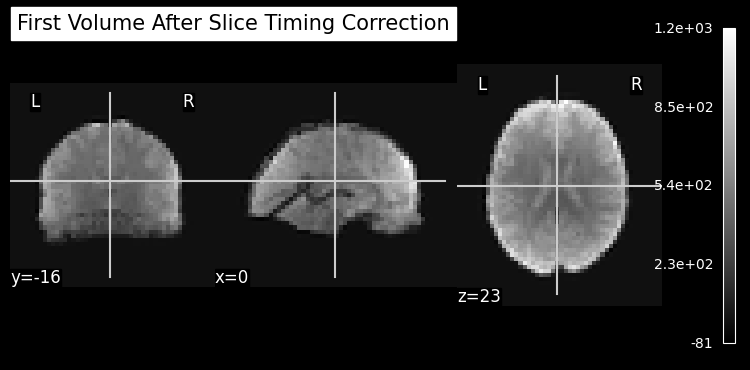

In [7]:
fmri_st = slice_timing_correction(fmri_img)
fmri_st_first_volume = index_img(fmri_st, 0)
plot_fmri_epi(fmri_st_first_volume, title="First Volume After Slice Timing Correction")

Different slices are acquired at different times within a TR. STC **shifts voxel timecourses** to align them to a common temporal reference.
❗STC does **NOT** change spatial intensities in any single volume.  That is why EPI slice plots before/after STC look identical.
We demonstrate conceptually by plotting voxel timecourses.

### Motion Correction (Realignment): Adjusting for Subject Movement

Motion is the single greatest source of artifact in fMRI, as even tiny head shifts ($\approx 1$ mm) can cause large, spurious signal changes.
- **The Method**: Motion correction (or realignment) aligns all 3D volumes in the 4D time series to a single reference volume (often the first or the middle volume).
  - **Algorithm**: It uses a rigid-body transformation (6 parameters: 3 translations—X, Y, Z—and 3 rotations—pitch, roll, yaw) to calculate the movement between each image volume and the reference.
  - **Output**: The images are resampled (shifted/rotated) to correct for the displacement, and a **motion parameter file** (a set of 6 time series) is generated. These parameters are later included as **confound regressors** in the statistical model to remove any residual motion effects from the BOLD time series.

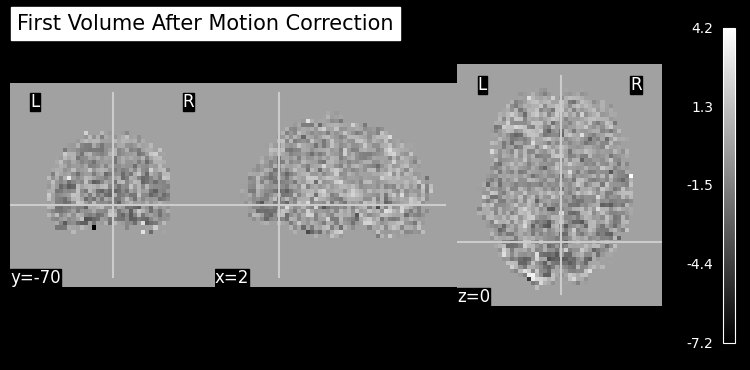

In [8]:
fmri_mc = motion_correction(fmri_st)
fmri_mc_first_volume = index_img(fmri_mc, 0)
plot_fmri_epi(fmri_mc_first_volume, title="First Volume After Motion Correction")

/var/folders/4w/jb7nh9ns51vcx_1p3nn151800000gn/T/ipykernel_17002/2517094199.py:2: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  mean_ref = mean_img(fmri_img)


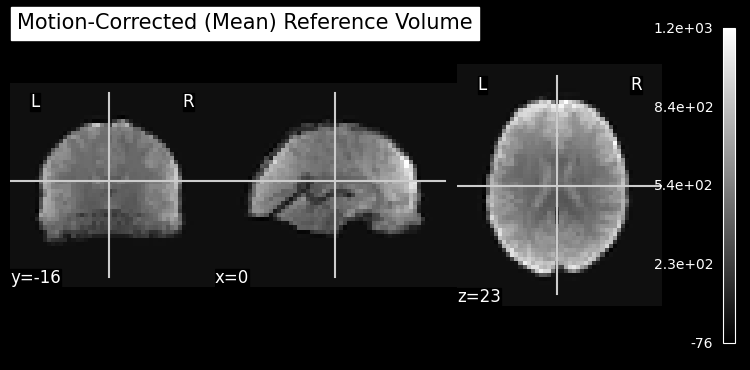

In [9]:
# Compute mean image as "motion-corrected reference"
mean_ref = mean_img(fmri_img)
plot_fmri_epi(mean_ref, title="Motion-Corrected (Mean) Reference Volume")

Motion correction does **not strongly change intensities** of any single volume.
Difference maps highlight tiny alignment changes — often < 1 voxel.

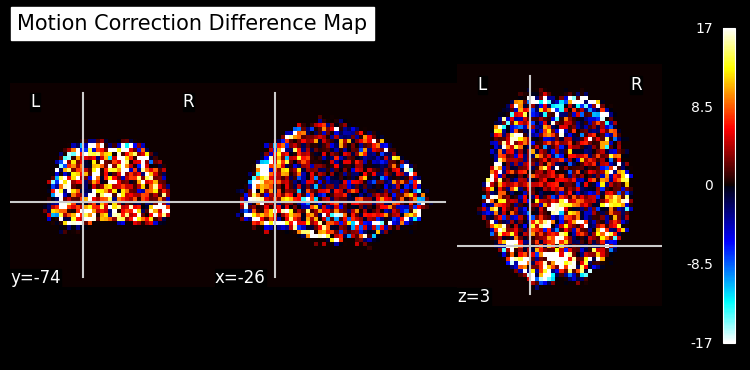

In [10]:
diff_mc = math_img("img1 - img2", img1=mean_ref, img2=first_volume_img)
plot_fmri_diffmap(diff_mc, title="Motion Correction Difference Map")

### Spatial Smoothing: Enhancing Sensitivity with Gaussian Kernels

**Spatial smoothing** involves blurring the fMRI data by convolving each 3D volume with a **Gaussian kernel** (a bell-shaped distribution). The extent of the blurring is defined by the **Full Width at Half Maximum (FWHM)**, typically $5$ to $8$ mm.

**Key Benefits and Purpose**:
1. **Increases Signal-to-Noise Ratio (SNR)**: Since the neural source of the BOLD signal is spatially diffuse, smoothing averages out high-spatial-frequency noise, effectively boosting the true underlying signal.
2. **Improves Inter-Subject Alignment**: Even after warping to a standard space, no two brains perfectly align. Smoothing ensures that activation from the same functional area is more likely to overlap across subjects, which is vital for Group-Level Statistics.
3. **Satisfies Statistical Assumptions**: Smoothing makes the spatial error components more normally distributed, which helps satisfy the assumptions of **Random Field Theory**—a mathematical foundation used in common fMRI software (like SPM) for controlling false positives.

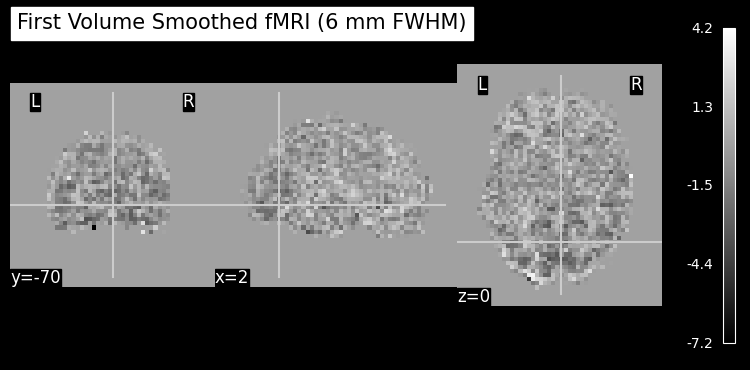

In [11]:
fmri_smoothed = smooth_image(fmri_mc, fwhm=6)
fmri_smoothed_first_volume = index_img(fmri_mc, 0)
plot_fmri_epi(fmri_smoothed_first_volume, title="First Volume Smoothed fMRI (6 mm FWHM)")

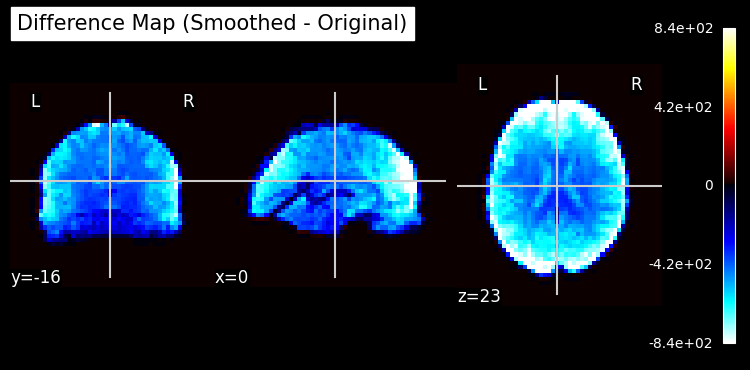

In [12]:
diff_smooth = math_img("img1 - img2", img1=fmri_smoothed_first_volume, img2=first_volume_img)
plot_fmri_diffmap(diff_smooth, title="Difference Map (Smoothed - Original)")

### About BIDS (Brain Imaging Data Structure): Standardizing Neuroimaging

BIDS is a standardized, community-driven convention for organizing neuroimaging and behavioral data. Its purpose is to make data management, sharing, and software pipelines (like fMRIPrep) consistent and robust.

**Core BIDS Concepts**:
- **Hierarchical Structure**: Data is organized by subject (`sub-XX`), session (`ses-YY`), and data type (`anat`, `func`, `dwi`, etc.).
- **Filename Convention**: Filenames use key-value pairs (`sub-01_task-rest_bold.nii.gz`) that specify the subject, task, and modality.
- **Metadata Files (`.json`)**: These accompanying files (e.g., `_bold.json`) contain critical scanning parameters not stored in the NIfTI image itself, such as:
  - Repetition Time (TR)
  - Slice Timing Sequence (needed for STC)
  - Echo Time (TE) / Flip Angle (FA)
- **Event Files (`_events.tsv`)**: Tab-separated value files that precisely log the onset, duration, and type of all experimental events—essential for creating the General Linear Model (GLM) in analysis.

By using BIDS, your preprocessing pipeline becomes easily transferable and reproducible by others in the scientific community.

In [14]:
metadata = load_fmri_metadata()
metadata

{'dim': (50, 59, 50, 168),
 'voxel_size': (np.float32(4.0),
  np.float32(4.0),
  np.float32(4.0),
  np.float32(1.0)),
 'datatype': 'int8',
 'TR': np.float32(1.0)}